# Parse and align Spike sequences

## Setup for analysis
Import modules and read configuration file:

In [1]:
import Bio.SeqIO

import pandas as pd

from plotnine import *

import yaml

with open('config.yaml') as f:
    config = yaml.safe_load(f)

## Parse human virus Spike sequences
Get the sequences into a data frame:

In [2]:
# read sequences
seqs = list(Bio.SeqIO.parse(config['genbank_sequences'], 'fasta'))

# get sequences into data frame
header_fields = ['id', 'gene', 'host', 'species', 'location']
assert all(s.description.count('|') + 1 == len(header_fields) for s in seqs)
df = pd.DataFrame.from_records([s.description.split('|') + [s] for s in seqs],
                               columns=header_fields + ['SeqRecord']
                               )

Flag human sequences and plot how many are human:

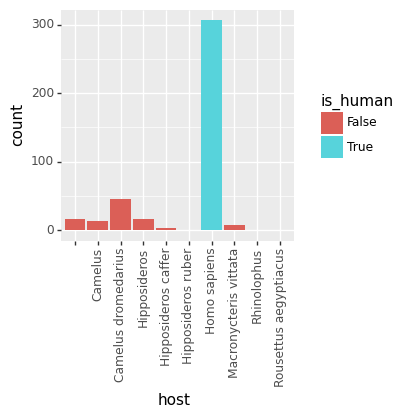

In [3]:
df['is_human'] = (df['host'] == 'Homo sapiens')

p = (ggplot(df) +
     aes('host', fill='is_human') +
     geom_bar() +
     theme(axis_text_x=element_text(angle=90),
           figure_size=(0.3 * df['host'].nunique(), 3))
     )

_ = p.draw()

Flag Spike sequences and plot how many of the human sequences are Spike or some other gene name:

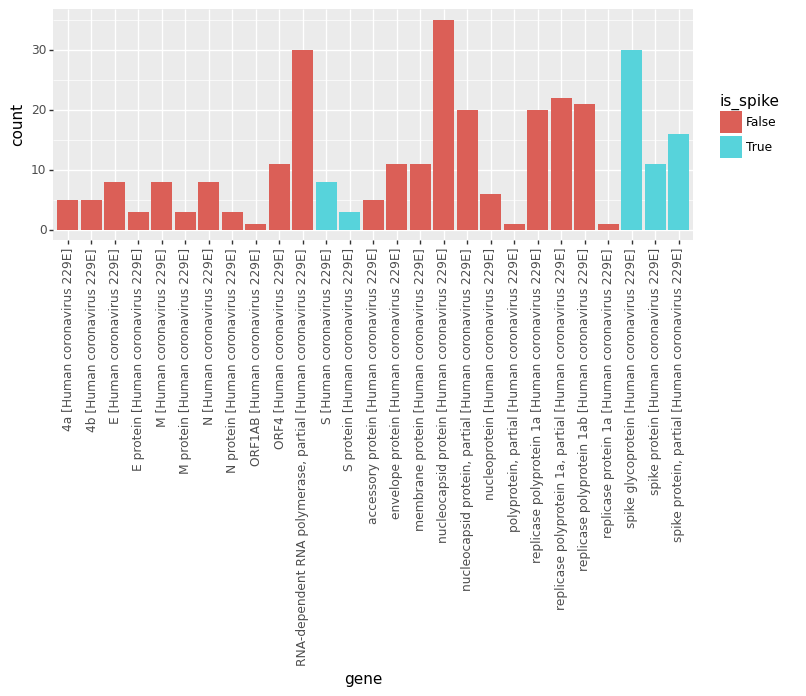

In [4]:
df['is_spike'] = df['gene'].str.match('^(S|s)')

p = (ggplot(df.query('is_human == True')) +
     aes('gene', fill='is_spike') +
     geom_bar() +
     theme(axis_text_x=element_text(angle=90),
           figure_size=(0.15 * df['gene'].nunique(), 3))
     )

_ = p.draw()

Now translate all proteins:

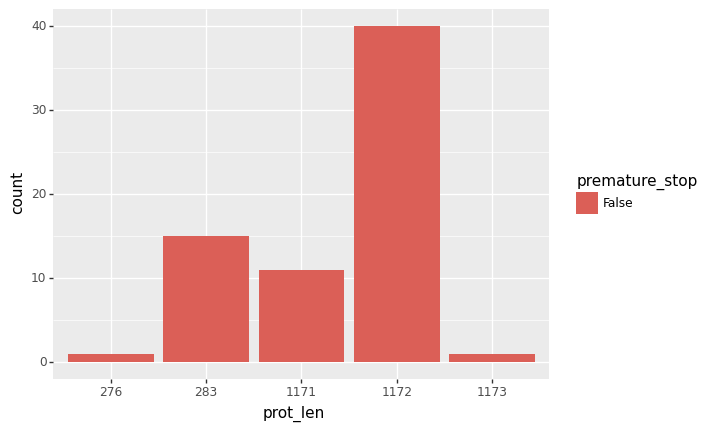

In [17]:
df = (
    df
    .assign(Seq=lambda x: x['SeqRecord'].map(lambda s: s.seq),
            prot=lambda x: x['Seq'].map(lambda s: s[: (len(s) // 3) * 3].translate()),
            premature_stop=lambda x: x['prot'].str[: -1].str.contains('*', regex=False),
            prot_len=lambda x: x['prot'].map(lambda p: len(p)),
            )
    )

p = (ggplot(df.query('(is_human == True) & (is_spike == True)')
              .assign(prot_len=lambda x: pd.Categorical(x['prot_len']))
            ) +
     aes('prot_len', fill='premature_stop') +
     geom_bar()
     )
_ = p.draw()

In [19]:
df['SeqRecord'].values[0]

SeqRecord(seq=Seq('ATGGCCTGCAACCGTGTGACACTTGCCGTAGCAAGTGATACTGAAATTTCTGCA...TAA', SingleLetterAlphabet()), id='join(NC_028752.1:293..12534,NC_028752.1:12534..20583)', name='join(NC_028752.1:293..12534,NC_028752.1:12534..20583)', description='join(NC_028752.1:293..12534,NC_028752.1:12534..20583) |polyprotein ORF1ab [Camel alphacoronavirus]|Camelus|Human coronavirus 229E|Saudi Arabia', dbxrefs=[])